In [1]:
import json
import os
import numpy as np
import pandas as pd
import copy
import pickle
import operator
import math

from numpy import exp, sqrt, dot
from scipy.spatial.distance import cdist

from sklearn.decomposition import PCA, KernelPCA, SparsePCA
from sklearn.preprocessing import scale
from sklearn.model_selection import StratifiedKFold

from sklearn import datasets

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# load data

In [2]:
def load_ionosphere_dataset():
    path = "./ionosphere/ionosphere.data"

    data = np.array(pd.read_csv(path, delimiter=","))
    data_y, data_x = data[:, -1], data[:, :-1]

    return data_x, data_y

In [3]:
def load_winequality_dataset():
    path_red_wine = "wine_quality/winequality-red.csv"
    path_white_wine = "wine_quality/winequality-white.csv"

    data_red = pd.read_csv(path_red_wine, delimiter=";")
    data_white = pd.read_csv(path_white_wine, delimiter=";")

    data = np.vstack((data_red, data_white))
    data_x = data[:, :-1]
    data_y = [0] * data_red.shape[0] + [1] * data_white.shape[0]

    return data_x, np.array(data_y)


In [4]:
def make_alternate_stripes():
    np.random.seed(0)
    
    data = []
    
    for i in [np.pi*i for i in [-3, -1, 1, 3, 5]]:
        
        noise = np.random.randn(200, 1)
        x = np.expand_dims(np.repeat(i, 200), axis=1) + noise
        y = noise
        
        concat = np.concatenate((x, y), axis=1)
        data.append(concat)
        
    for i in [np.pi*i for i in [-4, -2, 0, 2, 4]]:
        
        noise = np.random.randn(200, 1)
        x = np.expand_dims(np.repeat(i, 200), axis=1) + noise
        y = noise
        
        concat = np.concatenate((x, y), axis=1)
        data.append(concat)
        
    data_x = np.reshape(np.array(data), (2000, 2)) 
    data_y = np.array([0] * 1000 + [1] * 1000)
        
    return data_x, data_y
    

In [5]:
def fibonacci_sphere(r, samples=1000, mu=0, sigma=0.05):
    np.random.seed(0)

    points = []
    phi = math.pi * (3. - math.sqrt(5.))  # golden angle in radians

    for i in range(samples):
        y = 1 - (i / float(samples - 1)) * 2  # y goes from 1 to -1
        radius = math.sqrt(1 - y * y)  # radius at y

        theta = phi * i  # golden angle increment

        x = math.cos(theta) * radius
        z = math.sin(theta) * radius

        points.append((x, y, z))
        
        noise = np.random.randn(1000, 3)
        noise = noise * sigma + mu

    return np.array(points)*r+noise

def make_two_spheres():
    
    sphere_one = fibonacci_sphere(0.1)
    sphere_two = fibonacci_sphere(0.5)

    x = np.concatenate((sphere_one, sphere_two), axis=0)
    y = [1] * sphere_one.shape[0] + [0] * sphere_two.shape[0]
    
    return x, np.array(y)

In [79]:
def circles_data(x0=0, y0=0):
    np.random.seed(0)
    
    x, y =  datasets.make_circles(n_samples=2000, factor=0.1, noise=0.05)
    x[:, 0] += x0
    x[:, 1] += y0
    
    return x, y

In [71]:
def load_data(dataset):
    
    if dataset == "spheres":
        data_x, data_y = make_two_spheres()

    elif dataset == "circles":
        data_x, data_y = circles_data()

    elif dataset == "alternate_stripes":
        data_x, data_y = make_alternate_stripes()
            
    elif dataset == "wine_type":
        data_x, data_y = load_winequality_dataset()
        
    elif dataset == "ionosphere":
        data_x, data_y = load_ionosphere_dataset()
    
    return data_x, data_y


# arithmetic funcs

In [8]:
def protected_log(x):
    
    return np.log(np.abs(x) + 1e-6)

In [9]:
def protected_div(x1, x2):
    
    return (np.sign(x1)*x2)/(np.abs(x1) + 1e-6)

# plot the data

NameError: name 'x' is not defined

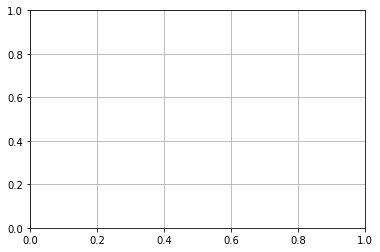

In [10]:
# Plot results

plt.figure()
plt.grid(True)

plt.scatter(x[:, 0], x[:, 1], c="blue", s=20, edgecolor="k")
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlabel("$x_1$", size=15)
plt.ylabel("$x_2$", size=15)
plt.savefig(f'original_{dataset}.pdf', dpi=600, bbox_inches='tight')
plt.show()

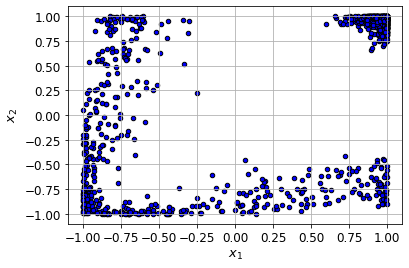

In [200]:
# Plot results

plt.figure()
plt.grid(True)

plt.scatter(np.cos(x[:, 0]+x[:, 0]), np.cos(x[:, 1]+x[:, 1]), c="blue", s=20, edgecolor="k")
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlabel("$x_1$", size=13)
plt.ylabel("$x_2$", size=13)
plt.savefig(f'original_{dataset}.pdf', dpi=600, bbox_inches='tight')
plt.show()

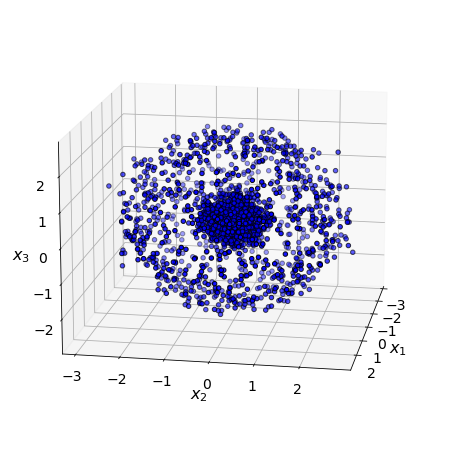

In [247]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[:, 0], x[:, 1], x[:, 2], s=20, c="blue", edgecolor="k")
ax.set_xlabel('$x_1$', fontsize=16)
ax.set_ylabel('$x_2$', fontsize=16)
ax.set_zlabel('$x_3$', fontsize=16)
for t in ax.xaxis.get_major_ticks(): 
    t.label.set_fontsize(14)
for t in ax.yaxis.get_major_ticks(): 
    t.label.set_fontsize(14) 
for t in ax.zaxis.get_major_ticks(): 
    t.label.set_fontsize(14)
ax.xaxis.set_rotate_label(False) 
ax.yaxis.set_rotate_label(False) 
ax.zaxis.set_rotate_label(False) 
ax.view_init(15, 10)
plt.savefig(f'original_{dataset}.pdf', dpi=600, bbox_inches='tight')
plt.show()

# Single out the amount of variance from original data in first k components

In [10]:
def if_empty_zero(array):
    
    if array.size == 0:
        array = 0
    
    return array

In [11]:
def compute_variance_contribution(cov, comp, k, l, d):
    
    lim_below = l
    lim_above = l+1
    
    first_term = comp[k, l]**2 * cov[l, l]
    
    f1 = comp[k, :lim_below] * comp[k, l] * cov[:lim_below, l]
    f2 = comp[k, lim_above:d] * comp[k, l] * cov[lim_above:d, l]
    
    second_term = np.sum(if_empty_zero(f1)) + np.sum(if_empty_zero(f2))
    contribution = first_term + second_term
    
    return contribution

In [12]:
def get_contribs(cov, comp, k, start, end):
    
    arr_contrib = [[] for _ in range(k)]

    for pc_num in range(k):
        for feature_num in range(start, end):

            contrib = compute_variance_contribution(cov, comp, pc_num, feature_num, k)
            arr_contrib[pc_num].append(contrib)
            
    return np.array(arr_contrib)

# load data

In [19]:
dataset = "circles"

In [272]:
mystring = "supfun0: cos( sin( ( x0 + x0 ) ) );\t supfun1: cos( sin( ( x1 + x1 ) ) );"

In [273]:
my_string = mystring.split("\t")

In [274]:
d_list = []

for i, s in enumerate(my_string):
    
    s = s[9:-1]
   
    s = s.replace("cos", "np.cos")
    s = s.replace("log", "protected_log")
    s = s.replace("sin", "np.sin")
    s = s.replace(f"x{i}", f"x[:, {i}]")
    
    d_list.append(s)

In [75]:
x, y = load_data(dataset)

In [276]:
d1 = eval(d_list[0])
d2 = eval(d_list[1])

if len(d_list) == 3:
    d3 = eval(d_list[2])

# transform variable

In [92]:
x_transformed, y = pickle.load(open("x_transformed.p", "rb"))

In [93]:
x_transformed, y = x_transformed[0], y[0]

In [50]:
x_transformed = np.transpose(np.vstack((d1, d2)))

NameError: name 'd1' is not defined

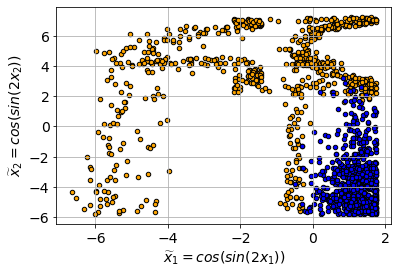

In [94]:
plt.plot()
plt.grid(True)
plt.scatter(x_transformed[y==0, 0], x_transformed[y==0, 1], c="orange", s=20, edgecolor="k")
plt.scatter(x_transformed[y==1, 0], x_transformed[y==1, 1], c="blue", s=20, edgecolor="k")
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlabel(r"$\widetilde{x}_1 = cos(sin(2x_1))$", size=14)
plt.ylabel(r"$\widetilde{x}_2 = cos(sin(2x_2))$", size=14)
plt.savefig(f'transformed_{dataset}.pdf', dpi=600, bbox_inches='tight')
plt.show()

# pca on original and transformed data

In [95]:
pca_method = "sparse"
pca_regularization = 0.1

In [96]:
num_org_dim = x.shape[1]

if pca_method == "sparse":
    pca = SparsePCA(n_components=num_org_dim, alpha=pca_regularization)
elif pca_method == "regular":
    pca = PCA(n_components=num_org_dim)
else:
    raise ValueError(f"problemo in the method name, {pca_method} not valid")

x = scale(x, axis=0)
    
pca.fit(x)
pca_x = pca.transform(x)

In [97]:
cov_matrix = np.cov(np.transpose(x))

In [98]:
org_contrib = get_contribs(np.cov(np.transpose(x)), pca.components_, num_org_dim, 0, num_org_dim)

In [99]:
print(org_contrib, np.sum(org_contrib[:1, :], axis=0))

[[0.50137103 0.50137103]
 [0.49962997 0.49962997]] [0.50137103 0.50137103]


In [100]:
print(np.sum(org_contrib, axis=1)) # this is the explained variance for each principal components

[1.00274207 0.99925993]


In [101]:
num_org_dim = x_transformed.shape[1]

if pca_method == "sparse":
    pca = SparsePCA(n_components=num_org_dim, alpha=pca_regularization)
elif pca_method == "regular":
    pca = PCA(n_components=num_org_dim)
else:
    raise ValueError(f"problemo in the method name, {pca_method} not valid")

x_transformed = scale(x_transformed, axis=0)
    
pca.fit(x_transformed)
pca_xt = pca.transform(x_transformed)

In [102]:
trans_contrib = get_contribs(np.cov(np.transpose(x_transformed)), pca.components_, num_org_dim, 0, num_org_dim) 
trans_components = pca.components_

In [103]:
print(trans_contrib)

[[0.66982658 0.66982658]
 [0.33079881 0.33079881]]


In [104]:
print(np.sum(trans_contrib[:1]), np.sum(trans_contrib[:1], axis=0)) # this is the explained variance for each principal components

1.3396531521421786 [0.66982658 0.66982658]


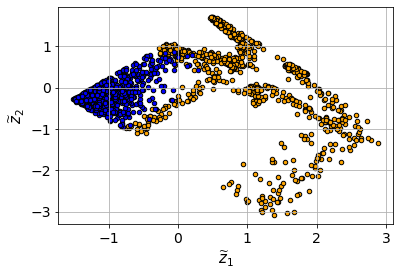

In [107]:
plt.plot()
plt.grid(True)
plt.scatter(pca_xt[y==0, 0], pca_xt[y==0, 1], c="orange", s=20, edgecolor="k")
plt.scatter(pca_xt[y==1, 0], pca_xt[y==1, 1], c="blue", s=20, edgecolor="k")
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlabel(r"$\widetilde{z}_1$", size=15)
plt.ylabel(r"$\widetilde{z}_2$", size=15)
plt.savefig(f'pc_{dataset}.pdf', dpi=600, bbox_inches='tight')
plt.show()

# analyse results from multiple runs

In [34]:
length = 5

In [35]:
def get_quantile(data, low_q):

    median = np.median(data, axis=0)
    low_quantile = np.quantile(data, low_q, axis=0)
    high_quantile = np.quantile(data, 1-low_q, axis=0)
    
    return median, low_quantile, high_quantile

In [40]:
def load_objectives_and_expressions(dataset):
    
    path = f"plots/GP_synthetic_datasets/result_{dataset}_len_{length}.p"
    result = pickle.load(open(path, "rb"))
    
    objective = np.reshape(np.array([r.objectives[0][0] for sublist in result for r in sublist]), (30,100))
    expression = np.reshape(np.array([r.GetHumanExpression() for sublist in result for r in sublist]), (30,100))
    
    return objective, expression

In [41]:
datasets = ["circles", "spheres", "alternate_stripes"]
color_array = ["darkblue", "darkgreen", "darkred"]

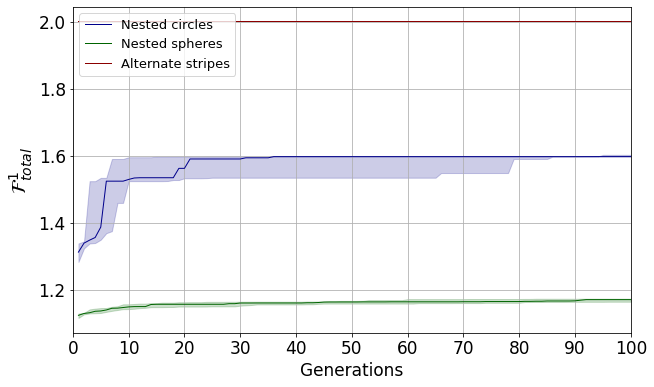

In [38]:
list_objectives = []
list_line_legend = []

my_range = np.arange(1, 101, 1)

plt.figure(figsize=(10,6))
plt.xlim(1, 100)
plt.xlabel("Generations", size=17)
plt.ylabel("$\mathcal{F}_{total}^{1}$", size=20)
plt.xticks(np.arange(0, 110, 10), np.arange(0, 110, 10), size=17)
plt.yticks(size=17)
plt.grid()

for i, dataset in enumerate(datasets):
    
    objective, expression = load_objectives_and_expressions(dataset)
    list_objectives.append((objective, expression))
    median, low_quantile, high_quantile = get_quantile(np.array(objective)*-1, 0.25)
    
    color = color_array[i]
    l, = plt.plot(my_range, median, color=color, linewidth=1)
    list_line_legend.append(l)
    plt.fill_between(my_range, np.array(low_quantile).astype('float64'), np.array(high_quantile).astype('float64'), 
                             color=color, alpha=0.2)

leg = plt.legend(list_line_legend, ["Nested circles", "Nested spheres", "Alternate stripes"], fontsize=13, loc="upper left")

for legobj in leg.get_lines():
    legobj.set_linewidth(1.0)

plt.savefig(f'objective_generations_length_{length}.pdf', dpi=600, bbox_inches='tight')
plt.show()

In [148]:
objective, expression = load_objectives_and_expressions("spheres")

In [149]:
np.argmax(objective*-1)

2780

In [150]:
np.concatenate(objective)[2780]

-1.1893730052911204

In [151]:
np.concatenate(expression)[2780]

'\t\tsupfun0: cos( sin( ( x0 + x0 ) ) );\tsupfun1: cos( sin( ( x1 + x1 ) ) );\tsupfun2: cos( sin( sin( sin( x2 ) ) ) );'